# Model Training

## Import Libraries And Dataset

In [69]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,RocCurveDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [70]:
df=pd.read_csv('../artifacts/clean_raw_data.csv')
df.head()

,merchant,category,amt,gender,zip,city_pop,is_fraud,age,hour,is_weekend
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,0,13820,0,weekday
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,99160,149,0,17369,0,weekday
2,fraud_Lind-Buckridge,entertainment,220.11,M,83252,4154,0,23366,0,weekday
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,0,21547,0,weekday
4,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,0,14532,0,weekday


## Preparing X And Y Variable

In [71]:
x=df.drop(columns=["is_fraud"],axis=1)
y = df["is_fraud"]

In [72]:
x.shape,y.shape


((9999, 9), (9999,))

## Train Test Split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape  

((7999, 9), (7999,), (2000, 9), (2000,))

## Frequency Encoding For merchant and zip

In [74]:
merchant_freq_map = X_train['merchant'].value_counts(normalize=True)
zip_freq_map = X_train['zip'].value_counts(normalize=True)

min_merchant_freq = merchant_freq_map.min()
min_zip_freq = zip_freq_map.min()

X_train['merchant_freq'] = X_train['merchant'].map(merchant_freq_map)
X_train['zip_freq'] = X_train['zip'].map(zip_freq_map)

X_test['merchant_freq'] = X_test['merchant'].map(merchant_freq_map).fillna(min_merchant_freq)
X_test['zip_freq'] = X_test['zip'].map(zip_freq_map).fillna(min_zip_freq)

X_train.drop(['merchant', 'zip'], axis=1, inplace=True)
X_test.drop(['merchant', 'zip'], axis=1, inplace=True)

with open("../artifacts/merchant_freq_map.pkl", "wb") as f:
    pickle.dump(dict(merchant_freq_map), f)

with open("../artifacts/zip_freq_map.pkl", "wb") as f:
    pickle.dump(dict(zip_freq_map), f)

## Merchant Frequency Vs Fraud Rate

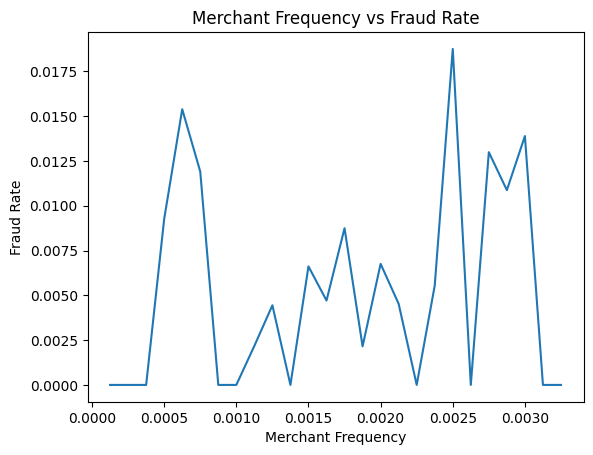

In [75]:
merchant_fraud = (
    pd.concat([X_train['merchant_freq'], y_train], axis=1)
    .groupby('merchant_freq')['is_fraud']
    .mean()
)

plt.figure()
merchant_fraud.plot()
plt.xlabel("Merchant Frequency")
plt.ylabel("Fraud Rate")
plt.title("Merchant Frequency vs Fraud Rate")
plt.show()


## Zip Frequency Vs Fraud Rate

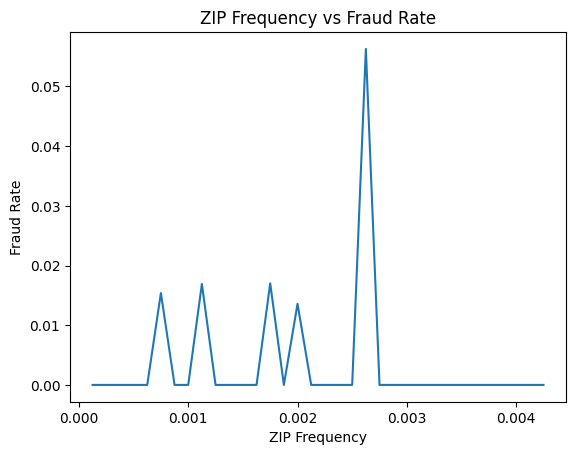

In [76]:
zip_fraud = (
    pd.concat([X_train['zip_freq'], y_train], axis=1)
    .groupby('zip_freq')['is_fraud']
    .mean()
)

plt.figure()
zip_fraud.plot()
plt.xlabel("ZIP Frequency")
plt.ylabel("Fraud Rate")
plt.title("ZIP Frequency vs Fraud Rate")
plt.show()


### Why Keep `merchant` and `zip`

- **Merchant**: Fraudulent transactions are more common with rare or infrequent merchants. Frequency encoding captures this risk effectively without increasing dimensionality.
- **ZIP Code**: Fraud likelihood varies by geographic location. Frequency encoding transforms ZIP codes into a meaningful numeric risk indicator.

**Conclusion:** Both features add strong predictive value and are retained using frequency encoding.


In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7999 entries, 9253 to 7270
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       7999 non-null   object 
 1   amt            7999 non-null   float64
 2   gender         7999 non-null   object 
 3   city_pop       7999 non-null   int64  
 4   age            7999 non-null   int64  
 5   hour           7999 non-null   int64  
 6   is_weekend     7999 non-null   object 
 7   merchant_freq  7999 non-null   float64
 8   zip_freq       7999 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 624.9+ KB


## Standard Scalling And OHE

In [78]:
num_features = [
    'amt',
    'city_pop',
    'age',
    'hour',
    'merchant_freq',
    'zip_freq'
]
cat_features = [
    'category',
    'gender',
    'is_weekend'
]
numeric_transformer=StandardScaler()
oh_transformer=OneHotEncoder()

preprocessor = ColumnTransformer(
   [
       ("StandardScaler",numeric_transformer,num_features),
       ("OneHotEncoder",oh_transformer,cat_features),
     
   ]
)

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)


## Our Dataset Is Imbalanced Using SMOTE

In [79]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

Before SMOTE: {0: 7958, 1: 41}
After SMOTE: {0: 7958, 1: 7958}


In [80]:
def evaluate_classification(y_true, y_pred, y_proba=None):
    results = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }
    
    if y_proba is not None: 
        results["roc_auc"] = roc_auc_score(y_true, y_proba)
    
    return results

In [81]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "CatBoost": CatBoostClassifier(verbose=0),
    "K-Neighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True), 
    "Naive Bayes": GaussianNB()
}

model_list = []
roc_list = []

for name, model in models.items():
   
    model.fit(X_train_res, y_train_res)


    y_pred = model.predict(X_test_processed)

    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_processed)[:, 1]

  
    results = evaluate_classification(y_test, y_pred, y_proba)

    model_list.append(name)
    roc_list.append(results.get("roc_auc", None))

    print(name)
    print("Test set performance:")
    print(f"- Accuracy: {results['accuracy']:.4f}")
    print(f"- Precision: {results['precision']:.4f}")
    print(f"- Recall: {results['recall']:.4f}")
    print(f"- F1 Score: {results['f1']:.4f}")
    if "roc_auc" in results:
        print(f"- ROC-AUC: {results['roc_auc']:.4f}")
    print(f"- Confusion Matrix:\n{results['confusion_matrix']}")
    print("="*40 + "\n")

Logistic Regression
Test set performance:
- Accuracy: 0.9390
- Precision: 0.0469
- Recall: 1.0000
- F1 Score: 0.0896
- ROC-AUC: 0.9975
- Confusion Matrix:
[[1872  122]
 [   0    6]]

Random Forest
Test set performance:
- Accuracy: 0.9995
- Precision: 0.8571
- Recall: 1.0000
- F1 Score: 0.9231
- ROC-AUC: 1.0000
- Confusion Matrix:
[[1993    1]
 [   0    6]]

AdaBoost
Test set performance:
- Accuracy: 0.9920
- Precision: 0.2727
- Recall: 1.0000
- F1 Score: 0.4286
- ROC-AUC: 1.0000
- Confusion Matrix:
[[1978   16]
 [   0    6]]

XGBoost
Test set performance:
- Accuracy: 0.9995
- Precision: 0.8571
- Recall: 1.0000
- F1 Score: 0.9231
- ROC-AUC: 1.0000
- Confusion Matrix:
[[1993    1]
 [   0    6]]

CatBoost
Test set performance:
- Accuracy: 0.9975
- Precision: 0.5455
- Recall: 1.0000
- F1 Score: 0.7059
- ROC-AUC: 1.0000
- Confusion Matrix:
[[1989    5]
 [   0    6]]

K-Neighbors
Test set performance:
- Accuracy: 0.9945
- Precision: 0.3529
- Recall: 1.0000
- F1 Score: 0.5217
- ROC-AUC: 0.998

## Model Evaluation & Selection Summary

Multiple machine learning models were evaluated on the test dataset to identify the most suitable approach for credit card fraud detection. Due to the highly imbalanced nature of the data, performance was assessed using **Precision, Recall, F1-score, and ROC-AUC**, rather than accuracy alone.

---

### Key Observations

- **Logistic Regression** achieved perfect recall but very low precision, leading to a high number of false positives. It serves well as a baseline model but is not suitable for deployment.
- **Random Forest** and **XGBoost** delivered the best overall performance, achieving:
  - High precision
  - Perfect recall (no fraud cases missed)
  - Excellent F1-score
  - Near-perfect ROC-AUC  
  These models demonstrate strong capability in capturing complex fraud patterns.
- **CatBoost** performed well but showed lower precision compared to Random Forest and XGBoost.
- **AdaBoost** and **K-Nearest Neighbors** detected fraud effectively but produced more false positives.
- **Support Vector Machine** missed at least one fraud case, which is risky in fraud detection scenarios.
- **Naive Bayes** performed poorly due to unrealistic independence assumptions and is not suitable for this problem.

---

### Model Selection

- **Primary Candidates:**  
  - Random Forest  
  - XGBoost  

These models provide the best trade-off between detecting all fraud cases (high recall) and minimizing false alerts (high precision).

---

### Important Consideration

- The test set contains a very small number of fraud cases.
- Near-perfect performance metrics may not fully generalize to unseen data.

---

### Next Steps

- **Hyperparameter tuning** will be performed using techniques such as Grid Search or Random Search to further optimize model performance.
- Stratified cross-validation will be used to ensure robustness.
- Decision threshold tuning will be explored to balance precision and recall for real-world deployment.

---

### Conclusion

Tree-based ensemble models currently show the strongest performance for fraud detection. Final model selection will be made after hyperparameter tuning and additional validation to ensure stability and generalization.
